In [1]:
import tensorflow.keras as keras

data = keras.datasets.mnist.load_data()

In [2]:
(X_train, y_train), (X_test, y_test) = data

In [3]:
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

In [4]:
from sklearn.decomposition import PCA

pca = PCA(0.99)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [5]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    
    # input layer
    model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))

    for i in range(hp.Int("layers", 1, 3)):
        model.add(keras.layers.Dense(
            units=hp.Int(f"units_{i}", 100, 500, 10),
            activation="relu"
        ))

    # output layer
    model.add(keras.layers.Dense(10, activation="softmax"))

    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [6]:
hp = kt.HyperParameters()
build_model(hp)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-29 22:08:57.582951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-29 22:08:57.583141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
import os

search_res_dir = os.path.join(os.curdir, "results")

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory=search_res_dir,
    project_name="MLP_mnist"
)

In [8]:
tuner.search(
    X_train, y_train, 
    epochs=10,
    batch_size=8192,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(patience=20)],
    validation_split=0.05
)

Trial 50 Complete [00h 00m 05s]
val_accuracy: 0.4399999976158142

Best val_accuracy So Far: 0.5093333125114441
Total elapsed time: 00h 05m 54s
INFO:tensorflow:Oracle triggered exit


In [9]:
model = tuner.get_best_models(num_models=1)[0]

In [10]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               99600     
                                                                 
 dense_1 (Dense)             (None, 10)                3010      
                                                                 
Total params: 102,610
Trainable params: 102,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
best_params = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_params)

In [14]:
history = model.fit(
    X_train, y_train, 
    epochs=500,
    batch_size=8192,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=20)],
    validation_split=0.05
)

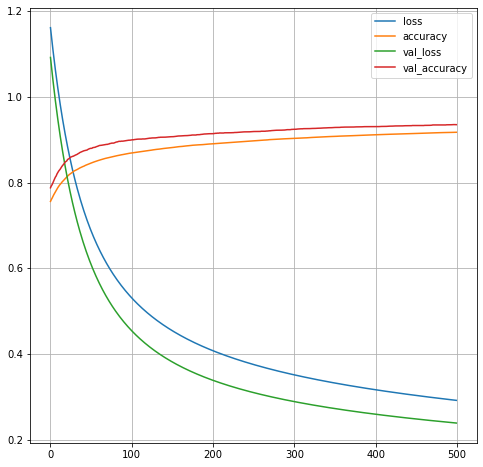

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 8))
plt.grid(True)
plt.show()

In [16]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.2767 - accuracy: 0.9230


[0.2767485976219177, 0.9230000376701355]

In [99]:
import numpy as np

id = 10
X_new, y_new = np.array([X_test[id]]), y_test[id]

In [100]:
X_new.shape

(1, 331)

In [101]:
X_pred = model.predict(X_new)

In [102]:
X_new = pca.inverse_transform(X_new)
X_new.shape

(1, 784)

In [103]:
X_new = X_new.reshape((28, 28))
X_new.shape

(28, 28)

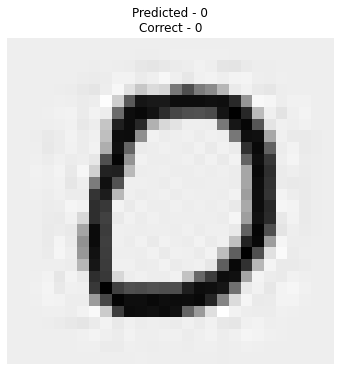

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(X_new, cmap="binary")
plt.axis(False)
X_pred = np.argmax(X_pred)
plt.title(f"Predicted - {X_pred}\nCorrect - {y_new}")
plt.show()

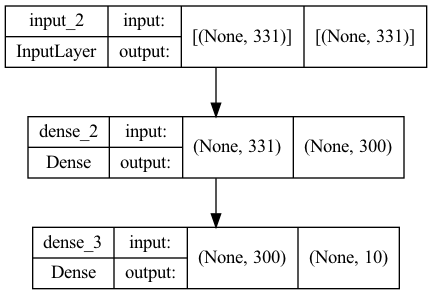

In [105]:
keras.utils.plot_model(model, "MLP_first.png", show_shapes=True)